<a href="https://colab.research.google.com/github/kamrulhuda/Time_Series_Analysis/blob/main/LSTM_02_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
#!pip install gdown
#!pip install tensorflow-gpu
#!pip install pymatreader
#!pip install phased-lstm-keras

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from pymatreader import read_mat
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import IPython
import plotly.express as px
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
tf.__version__

'2.5.0'

In [4]:
tf.keras.__version__

'2.5.0'

In [5]:
pd.__version__

'1.1.5'

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
train_data_norm = read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Train/TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.mat")
test_data_norm_25degC= read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Test/04_TEST_LGHG2@25degC_Norm_(05_Inputs).mat")
test_data_norm_10degC= read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Test/03_TEST_LGHG2@10degC_Norm_(05_Inputs).mat")
test_data_norm_0degC= read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Test/02_TEST_LGHG2@0degC_Norm_(05_Inputs).mat")
test_data_norm_n10degC= read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Test/01_TEST_LGHG2@n10degC_Norm_(05_Inputs).mat")
validation_data_norm= read_mat("/content/drive/MyDrive/Colab Notebooks/LG_Kamrul_Datasets/LG_Prepared/Validation/01_TEST_LGHG2@n10degC_Norm_(05_Inputs).mat")

In [8]:
feature_validation_norm =pd.DataFrame(validation_data_norm['X'])
feature_validation_norm= feature_validation_norm.T
feature_validation_norm= feature_validation_norm.iloc[: , :-2]

label_validation_norm=pd.DataFrame(validation_data_norm['Y'])

feature_validation_norm= feature_validation_norm.rename(columns={0: 'Voltage'}, index={'ONE': 'Row_1'})
feature_validation_norm= feature_validation_norm.rename(columns={1: 'Current'}, index={'ONE': 'Row_1'})
feature_validation_norm= feature_validation_norm.rename(columns={2: 'Batt_Temp'}, index={'ONE': 'Row_1'})
feature_validation_norm= feature_validation_norm.rename(columns={3: 'Avg_Voltage'}, index={'ONE': 'Row_1'})
feature_validation_norm= feature_validation_norm.rename(columns={4: 'Avg_Curr'}, index={'ONE': 'Row_1'})

label_validation_norm= label_validation_norm.rename(columns={0: 'SOC'}, index={'ONE': 'Row_1'})

validation_data=[feature_validation_norm,label_validation_norm]
validation_data=pd.concat(validation_data, axis=1) 

In [82]:
validation_data.head()

,Voltage,Current,Batt_Temp,SOC
0,0.967308,0.749218,0.005644,1.000000
1,0.957333,0.746992,0.005644,0.999990
2,0.953690,0.747098,0.005644,0.999983
3,0.952046,0.747098,0.005644,0.999973
4,0.951106,0.747098,0.005644,0.999963


In [9]:
feature_test_norm_25deC =pd.DataFrame(test_data_norm_25degC['X'])
feature_test_norm_25deC= feature_test_norm_25deC.T
feature_test_norm_25deC= feature_test_norm_25deC.iloc[: , :-2]

label_test_norm_25deC=pd.DataFrame(test_data_norm_25degC['Y'])

feature_test_norm_25deC= feature_test_norm_25deC.rename(columns={0: 'Voltage'}, index={'ONE': 'Row_1'})
feature_test_norm_25deC= feature_test_norm_25deC.rename(columns={1: 'Current'}, index={'ONE': 'Row_1'})
feature_test_norm_25deC= feature_test_norm_25deC.rename(columns={2: 'Batt_Temp'}, index={'ONE': 'Row_1'})
feature_test_norm_25deC= feature_test_norm_25deC.rename(columns={3: 'Avg_Voltage'}, index={'ONE': 'Row_1'})
feature_test_norm_25deC= feature_test_norm_25deC.rename(columns={4: 'Avg_Curr'}, index={'ONE': 'Row_1'})

label_test_norm_25deC= label_test_norm_25deC.rename(columns={0: 'SOC'}, index={'ONE': 'Row_1'})

In [10]:
test_data_25degC= [feature_test_norm_25deC,label_test_norm_25deC]
test_data_25degC=pd.concat(test_data_25degC, axis=1)

In [85]:
test_data_25degC.head()

,Voltage,Current,Batt_Temp,SOC
0,0.966960,0.748900,0.920678,1.000000
1,0.966020,0.746992,0.920677,0.999990
2,0.965901,0.746992,0.917845,0.999983
3,0.965783,0.747098,0.917845,0.999973
4,0.965665,0.746992,0.917845,0.999963


In [11]:
feature_train_norm =pd.DataFrame(train_data_norm['X'])
feature_train_norm= feature_train_norm.T
feature_train_norm= feature_train_norm.iloc[: , :-2]


label_train_norm=pd.DataFrame(train_data_norm['Y'])

feature_train_norm= feature_train_norm.rename(columns={0: 'Voltage'}, index={'ONE': 'Row_1'})
feature_train_norm= feature_train_norm.rename(columns={1: 'Current'}, index={'ONE': 'Row_1'})
feature_train_norm= feature_train_norm.rename(columns={2: 'Batt_Temp'}, index={'ONE': 'Row_1'})
feature_train_norm= feature_train_norm.rename(columns={3: 'Avg_Voltage'}, index={'ONE': 'Row_1'})
feature_train_norm= feature_train_norm.rename(columns={4: 'Avg_Curr'}, index={'ONE': 'Row_1'})

label_train_norm= label_train_norm.rename(columns={0: 'SOC'}, index={'ONE': 'Row_1'})

In [87]:
feature_train_norm.head()

,Voltage,Current,Batt_Temp
0,0.385148,0.75102,0.303101
1,0.385152,0.75102,0.304591
2,0.385156,0.75102,0.306081
3,0.385160,0.75102,0.307572
4,0.385164,0.75102,0.309062


In [88]:
label_train_norm.head()

,SOC
0,0.206417
1,0.206417
2,0.206417
3,0.206417
4,0.206417


In [12]:
train_data= [feature_train_norm,label_train_norm]
train_data=pd.concat(train_data, axis=1)

In [90]:
train_data.head()

,Voltage,Current,Batt_Temp,SOC
0,0.385148,0.75102,0.303101,0.206417
1,0.385152,0.75102,0.304591,0.206417
2,0.385156,0.75102,0.306081,0.206417
3,0.385160,0.75102,0.307572,0.206417
4,0.385164,0.75102,0.309062,0.206417


In [91]:
train_data.corr()

,Voltage,Current,Batt_Temp,SOC
Voltage,1.000000,0.291790,-0.025037,0.934111
Current,0.291790,1.000000,0.326081,-0.010492
Batt_Temp,-0.025037,0.326081,1.000000,-0.223576
SOC,0.934111,-0.010492,-0.223576,1.000000


In [92]:
print ("Rows     : " ,train_data.shape[0])
print ("Columns  : " ,train_data.shape[1])
print ("\nFeatures : \n" ,train_data.columns.tolist())
print ("\nMissing values :  ", train_data.isnull().any())
print ("\nUnique values :  \n",train_data.nunique())

Rows     :  669956
Columns  :  4

Features : 
 ['Voltage', 'Current', 'Batt_Temp', 'SOC']

Missing values :   Voltage      False
Current      False
Batt_Temp    False
SOC          False
dtype: bool

Unique values :  
 Voltage      410985
Current      230487
Batt_Temp    271371
SOC          368621
dtype: int64


In [13]:
num_x_signals=feature_train_norm.shape[1]
print(num_x_signals)

num_y_signals=label_test_norm_25deC.shape[1]
print(num_y_signals)

3
1


In [14]:
train_data = train_data['SOC'].shift(+10)

In [17]:
x_train= feature_train_norm
print(x_train.shape)
y_train= label_train_norm
print(y_train.shape)

(669956, 3)
(669956, 1)


In [18]:
x_validation= feature_validation_norm
print(x_validation.shape)
y_validation= label_validation_norm
print(y_validation.shape)

(39293, 3)
(39293, 1)


In [19]:
x_test_25degC= feature_test_norm_25deC
print(x_test_25degC.shape)
y_test_25degC= label_test_norm_25deC
print(y_test_25degC.shape)

(47517, 3)
(47517, 1)


In [20]:
num_train= train_data.shape[0]
print(num_train)
num_test= test_data_25degC.shape[0]
print(num_test)

669956
47517


In [21]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [22]:
batch_size= 256

In [23]:
sequence_length = 60*15
sequence_length

900

In [24]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [25]:
x_batch, y_batch = next(generator)

In [26]:
print(x_batch.shape)
print(y_batch.shape)

(256, 900, 3)
(256, 900, 1)


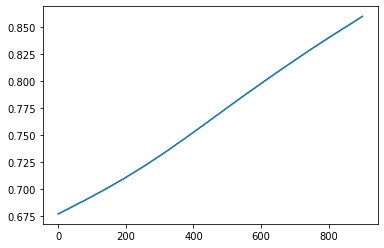

In [105]:
batch = 100   # First sequence in the batch.
signal = 0  # First signal from the 5 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

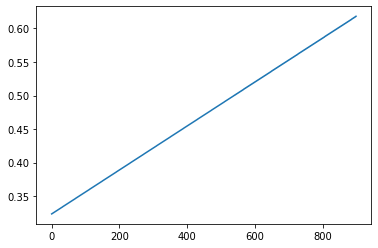

In [106]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [107]:
validation_data = (np.expand_dims(x_validation, axis=0),
                   np.expand_dims(y_validation, axis=0))

In [108]:

model = Sequential()

In [109]:
model.add(GRU(units=10,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [110]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [111]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [112]:
warmup_steps = 50

In [113]:

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [114]:
optimizer = RMSprop(learning_rate=1e-3)

In [115]:

model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [116]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 10)          450       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           11        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [117]:

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [118]:

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [119]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [120]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [121]:

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [195]:
%%time
history= model.fit(x=generator,
          epochs=5,
          steps_per_epoch=50,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/5
50/50 [==============================] - 20s 406ms/step - loss: 0.0050 - val_loss: 0.0069

Epoch 00001: val_loss improved from 0.01072 to 0.00690, saving model to 23_checkpoint.keras
Epoch 2/5
50/50 [==============================] - 19s 388ms/step - loss: 0.0040 - val_loss: 0.0070

Epoch 00002: val_loss did not improve from 0.00690

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/5
50/50 [==============================] - 20s 394ms/step - loss: 0.0035 - val_loss: 0.0066

Epoch 00003: val_loss improved from 0.00690 to 0.00657, saving model to 23_checkpoint.keras
Epoch 4/5
50/50 [==============================] - 19s 380ms/step - loss: 0.0033 - val_loss: 0.0062

Epoch 00004: val_loss improved from 0.00657 to 0.00624, saving model to 23_checkpoint.keras
Epoch 5/5
50/50 [==============================] - 19s 391ms/step - loss: 0.0032 - val_loss: 0.0059

Epoch 00005: val_loss improved from 0.00624 to 0.00595, saving model to 23_checkpoint.

In [196]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [197]:
result = model.evaluate(x=np.expand_dims(x_validation, axis=0),
                        y=np.expand_dims(y_validation, axis=0))

1/1 [==============================] - 1s 877ms/step - loss: 0.0059


In [198]:

print("loss (test-set):", result)

loss (test-set): 0.005947306286543608


In [199]:

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

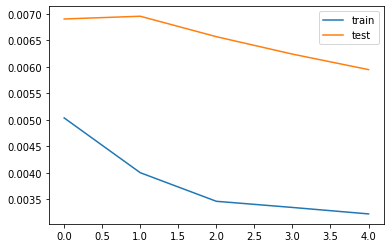

In [200]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [193]:

def plot_comparison(length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train
        y_true = y_train
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    #x = x[start_idx:end_idx]
    #y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)

    #y_pred = pd.DataFrame(y_pred)
    #y_true = pd.DataFrame(y_true)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    #y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    plt.plot(y_pred)
    plt.show()


    return y_pred, y_train

ValueError: ignored

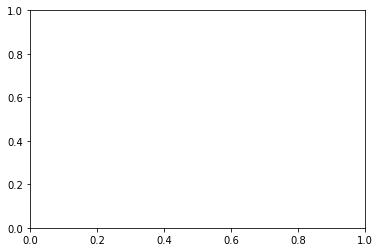

In [194]:
plot_comparison(length=1000, train=True)

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(x_train.shape[0], x_train.shape[1])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:

history = model.fit(
    x=generator, 
    epochs=5, 
    batch_size=10, 
    validation_split=validation_data,
   
)

ValueError: ignored

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(x_test)